In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils as ut

In [2]:
import os
import glob
files = glob.glob('profiles/*.pkl')

profiles_train = {}
profiles_val = {}

for i, file in enumerate(files):
    with open(file, 'rb') as f:
        tmp = pickle.load(f)

        if i in [2, 3, 4, 5, 6, 7]:
            profiles_train = {**profiles_train, **tmp}

        else:
            profiles_val = {**profiles_val, **tmp}

In [3]:
X_train = {key: ut.profile_to_df(value) for key, value in profiles_train.items() if 'layer' in value.keys()}
X_val = {key: ut.profile_to_df(value) for key, value in profiles_val.items() if 'layer' in value.keys()}

print(len(X_train))

276


We will build a simple train/val/test data set where we will gather profiles from similar surveys in a training/validation manner while omitting some surveys completely. Let's import some dummy functions made by ChatGPT to build a simple CNN

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

class SignalDataset(Dataset):
    def __init__(self, data_dict):
        self.data = data_dict
        self.le = LabelEncoder().fit(['B', 'S', 'WL']) 
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get profile key
        key = list(self.data.keys())[idx]
        features, labels = self.data[key]

        # Convert to tensors
        features = torch.tensor(features.values, dtype=torch.float32)  # Shape: (seq_len, num_features)
        labels = torch.tensor(self.le.transform(labels), dtype=torch.long)     # Shape: (seq_len,)

        return {
            "input_features": features,
            "labels": labels,
            "attention_mask": torch.ones(features.shape[0], dtype=torch.long)  # No padding yet
        }
    
train_dataset = SignalDataset(X_train)
val_dataset = SignalDataset(X_val)

In [7]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_features = [item["input_features"] for item in batch]
    labels = [item["labels"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]

    # Pad sequences to the same length
    input_features = pad_sequence(input_features, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for ignored labels
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        "input_features": input_features,
        "labels": labels,
        "attention_mask": attention_masks
    }

from torch.utils.data import DataLoader

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class EncoderDecoder(nn.Module):
    def __init__(self, input_shape, output_shape, rnn_size=256, dropout=0.2, dense_units=0):
        super(EncoderDecoder, self).__init__()
        
        self.input_size = input_shape[1]  # Number of features
        self.output_size = output_shape  # Number of output labels
        self.rnn_size = rnn_size  # LSTM hidden units
        self.dropout = dropout  # Dropout rate
        
        # Encoder (LSTM or Bidirectional LSTM)
        self.encoder_lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.rnn_size, num_layers=1, 
                                        bidirectional=True, dropout=self.dropout, batch_first=True)


        self.attention_layer = nn.MultiheadAttention(embed_dim=rnn_size * 2, num_heads=1, dropout=self.dropout)
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(input_size=rnn_size * 2, hidden_size=rnn_size, num_layers=1, dropout=self.dropout, batch_first=True)
        
        # Output layer (Dense)
        self.output_layer = nn.Linear(rnn_size, self.output_size)
        
    def forward(self, x):

        encoder_output, (h, c) = self.encoder_lstm(x)
        
        # The input to attention layer must be in (seq_len, batch, embed_dim) format
        encoder_output = encoder_output.permute(1, 0, 2)
        attn_output, _ = self.attention_layer(encoder_output, encoder_output, encoder_output)
        attn_output = attn_output.permute(1, 0, 2)

        # Decoder (Repeat context vector or use attention)
        decoder_input = attn_output  # In a typical Seq2Seq, we'd use the previous output as input, here we just pass the context vector
        decoder_output, (h, c) = self.decoder_lstm(decoder_input)
        
        # Output layer
        output = self.output_layer(decoder_output)
        output = torch.softmax(output, dim=-1)
        
        return output


In [ ]:
from tqdm import tqdm
# Initialize Model, Loss, Optimizer
num_channels = 11  # Number of features in your signal (channels)
num_classes = 3    # Number of classes for segmentation
model = EncoderDecoder((None, num_channels), num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padded labels

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_curve = []

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_features = batch["input_features"].to(device)
        labels = batch["labels"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        # Forward pass
        outputs = model(input_features)
        loss = loss_fn(outputs.view(-1, num_classes), labels.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
        loss_curve.append(loss.item())

c:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch 0:  30%|███       | 21/69 [01:18<03:36,  4.50s/it, loss=0.881]

In [15]:
import torch
from torch import nn, optim
import torch.nn.functional as F

class UNet1D(nn.Module):
    def __init__(self, input_channels, output_channels, features=(64, 128, 256, 512)):
        super(UNet1D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Encoder: Down-sampling
        for feature in features:
            self.encoder.append(
                nn.Sequential(
                    nn.Conv1d(input_channels, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv1d(feature, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                )
            )
            input_channels = feature

        # Decoder: Up-sampling
        for feature in reversed(features):
            self.decoder.append(
                nn.Sequential(
                    nn.Conv1d(2 * feature, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv1d(feature, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                )
            )
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.upsample = nn.ConvTranspose1d(feature, feature // 2, kernel_size=2, stride=2)

        # Final output layer
        self.final_layer = nn.Conv1d(features[0], output_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        skip_connections = skip_connections[::-1]

        # Decoder
        for idx, layer in enumerate(self.decoder):
            x = self.upsample(x)
            if x.size(-1) != skip_connections[idx].size(-1):
                x = F.pad(x, (0, skip_connections[idx].size(-1) - x.size(-1)))
            x = torch.cat((skip_connections[idx], x), dim=1)
            x = layer(x)

        # Final output
        return self.final_layer(x)

In [40]:
profiles, labels = np.array(list(X_train.values()), dtype='object').T

In [ ]:
dataset = SequenceDataset(profiles, labels)
dataloaer = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: (
    torchd.nn.utils.rnn.pad_sequence([torch.tensor(p[0]) for p in x], batch_first=True),
    torch.nn.utils.rnn.pad_sequence([torch.tensor(p[1]) for p in x], batch_first=True, padding_value=-1)
))

input_dim = np.shape(profiles[0])[-1]
num_classes = 2

#model = TransformerModel(input_dim, num_classes)
criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore padding in labels
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, dataloader, criterion, optimizer)

6/6, loss: 0.069
epoch 1/1000, average loss: 0.100
6/6, loss: 0.086
epoch 2/1000, average loss: 0.101
6/6, loss: 0.059
epoch 3/1000, average loss: 0.097
6/6, loss: 0.124
epoch 4/1000, average loss: 0.103
6/6, loss: 0.066
epoch 5/1000, average loss: 0.098
6/6, loss: 0.061
epoch 6/1000, average loss: 0.096
6/6, loss: 0.031
epoch 7/1000, average loss: 0.095
6/6, loss: 0.152
epoch 8/1000, average loss: 0.109
6/6, loss: 0.184
epoch 9/1000, average loss: 0.111
6/6, loss: 0.079
epoch 10/1000, average loss: 0.098
6/6, loss: 0.149
epoch 11/1000, average loss: 0.107
6/6, loss: 0.116
epoch 12/1000, average loss: 0.102
6/6, loss: 0.064
epoch 13/1000, average loss: 0.096
6/6, loss: 0.105
epoch 14/1000, average loss: 0.102
6/6, loss: 0.066
epoch 15/1000, average loss: 0.097
6/6, loss: 0.056
epoch 16/1000, average loss: 0.096
6/6, loss: 0.105
epoch 17/1000, average loss: 0.101
6/6, loss: 0.131
epoch 18/1000, average loss: 0.104
6/6, loss: 0.132
epoch 19/1000, average loss: 0.107
6/6, loss: 0.072
epoc

KeyboardInterrupt: 

In [90]:
tmp = torch.tensor(dataset[2][0]).float()
tmp = tmp.reshape(1, *tmp.shape)
out = model.forward(tmp)

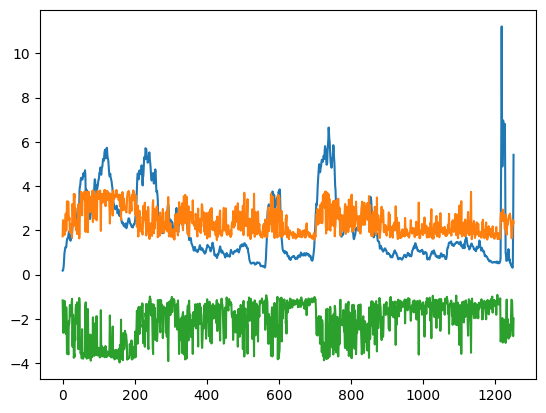

In [91]:
plt.plot(tmp[0][:, 0])
plt.plot(out[0].detach())